In [ ]:
# Requires directories named "figures" and "frames" to be present

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import csv



# get in-strength of directed graph g
def compute_in_strength(g, node):
    # all incoming edges
    in_edges = g.in_edges(node, data=True)
    # add up their in-weights
    in_strength = sum(data['weight'] for _, _, data in in_edges)
    return in_strength


def compute_out_strength(g, node):
    # all outgoing edges
    out_edges = g.out_edges(node, data=True)
    # out_weights
    out_strength = sum(data['weight'] for _, _, data in out_edges)
    return out_strength


def weighted_directed_time_aggregation(G_dict):
    '''
    Build time-aggregated network (weighted by flow of nutrients)
    Input: G_dict (dictionary of graph snapshots)

    '''
    
    # initialize a directed graph
    GG = nx.DiGraph()
    
    # loop over graph snapshots
    for g in G_dict.values():
    
        # loop over edges
        for i,j,data in g.edges(data=True):
    
            # increment the weight at the link (i,j)
            w = data['weight']
            prev_data = GG.get_edge_data(i,j)
            GG.add_edge(i,j, key='edge', weight = data['weight'] + w)

    return GG

def get_undirected(GG):
    # make an undirected graph g with the same node-set as GG but no weights/directionality
    g = nx.Graph()
    g.add_nodes_from(GG.nodes())
    for i,j in GG.edges():
        g.add_edge(i,j)
    return g



def build_graph_sequence(E,years,nodes):
    
    G = {year:nx.DiGraph() for year in years}
    
    for year in years:
        G[year].add_nodes_from(nodes)
    
    for i,j,w,t in E:
        G[t].add_edge(i,j,weight=w)
    
    return G


In [2]:
# select nutrient whose flow to analyze
nutrient = 8 # iron_sum

# other options:
#4 '"protein_sum"',
#5 '"fattyacids_sum"',
#6 '"calcium_sum"',
#7 '"zinc_sum"',
#8 '"iron_sum"',
#9 '"vita_sum"',
#10 '"vitb12_sum"',
#11 '"protein_norm"',
#12 '"fattyacids_norm"',
#13 '"calcium_norm"',
#14 '"zinc_norm"',
#15 '"iron_norm"',
#16 '"vita_norm"',
#17 '"vitb12_norm"',
#18 '"shannon_diversity"',
#19 '"norm_sum"'

# build temporal edgelist wight weights being nutrient flows
E = []

# read from nutrition data file
with open('data/nut_pict_hs160414.csv') as f:
    rea = csv.reader(f,delimiter = ' ')

    # extract data
    for jrow,row in enumerate(rea):

        # column names
        if jrow == 0:
            headers = row[0].split(',')

        # exporter, importer, year, nutrient flow
        else:
            values = row[0].split(',')
            expo = str(values[1].strip("\""))
            impo = str(values[0].strip("\""))
            year = int(values[2])
            weig = float(values[nutrient])

            # add as a tuple encoding a weighted temporal edge
            E.append((expo,impo,weig,year))

# obtain all nodes appearing throughout
nodes = set([e[0] for e in E]).union(set([e[1] for e in E]))

# years in the dataset
years = sorted(list(set([e[3] for e in E])))

# construct sequence of weighted directed graphs by year
G = build_graph_sequence(E,years,nodes)

# obtain time-aggregated network
GG = weighted_directed_time_aggregation(G)

# obtain strengths/surplusses
in_stre = {node: compute_in_strength(GG,node) for node in nodes}
ou_stre = {node: compute_out_strength(GG,node) for node in nodes}
surplus = {v:(ou_stre[v]-in_stre[v]) for v in GG.nodes()}

# label PICs as such
PICs = {"FJI", "FSM", "KIR", "MHL", 
        "NRU", "PLW", "PNG", "SLB", 
        "TON", "TUV", "VUT", "WSM"}

# all the rest are non-PICs
nonPICs = nodes.difference(PICs)


# Snapshot visualizations

In [3]:
# get undirected graph for embedding
GGG = get_undirected(GG)
po = nx.kamada_kawai_layout(get_undirected(GG))

# Determine x-axis and y-axis limits
xlow = np.min([p[0] for p in po.values()]) - 0.1
xhigh = np.max([p[0] for p in po.values()]) + 0.1
ylow = np.min([p[1] for p in po.values()]) - 0.1
yhigh = np.max([p[1] for p in po.values()]) + 0.1


# color assignment to PICs
np.random.seed(1000)
co = {v:(0.3+0.7*np.random.rand()**0.5,0.3+0.5*np.random.rand(),np.random.rand()**2) if v in PICs else 'lightgrey' for v in nodes}
cov = np.array([co[v] for v in GG.nodes],dtype=object)   # vector of node-colors

# visualize graph structure at each year
for jy,y in enumerate(years):
    
    fi,ax = plt.subplots(1,figsize=(4,4),dpi=200)
    # set a fixed x/y limit for all snapshots
    plt.xlim(xlow,xhigh)
    plt.ylim(ylow,yhigh)

    # draw nodes and edges
    nx.draw_networkx_edges(G[y], edge_color='black', pos=po)
    nx.draw_networkx_nodes(G[y], node_size=50, node_color=cov, pos=po)
    nx.draw_networkx_labels(G[y],pos = po, font_size=5)
    plt.box(False)
    plt.xlabel('$%i$'%y)
    
    plt.savefig('frames/pdf_year%i.pdf'%y)

    # save as png for conversion to gif 
    plt.savefig('frames/year_%04i.png'%jy)
    
    plt.close()


'''
 gif made by the following commands:

ffmpeg -framerate 10 -i frames/year_%04d.png -vf "fps=10,scale=500:-1:flags=lanczos,palettegen" -y palette.png
ffmpeg -framerate 10 -i frames/year_%04d.png -i palette.png -lavfi "fps=5,scale=1000:-1:flags=lanczos [x]; [x][1:v] paletteuse" -y out.gif

'''


'\n gif made by the following commands:\n\nffmpeg -framerate 10 -i frames/year_%04d.png -vf "fps=10,scale=500:-1:flags=lanczos,palettegen" -y palette.png\nffmpeg -framerate 10 -i frames/year_%04d.png -i palette.png -lavfi "fps=5,scale=1000:-1:flags=lanczos [x]; [x][1:v] paletteuse" -y out.gif\n\n'

# Local node statistics

In [4]:
# print out local degree/strength/surplus info

print('highest out-degree:')
print(sorted(GG.out_degree(),key=lambda z:z[1],reverse=True)[0:10])

print('\n\n highest in-degree:')
print(sorted(GG.in_degree(),key=lambda z:z[1],reverse=True)[0:10])

print('highest out-strength:')
print(sorted(ou_stre.items(),key=lambda z:z[1],reverse=True)[0:10])

print('\n\n highest in-strength:')
print(sorted(in_stre.items(),key = lambda z:z[1],reverse=True)[0:10])

print('\n\n highest surplus (positive net exports)')
print(sorted(surplus.items(),key = lambda z:z[1],reverse=True)[0:10])

print('\n\n lowest surplus (highest deficit, negative net exports)')
print(sorted(surplus.items(),key = lambda z:z[1],reverse=False)[0:10])


highest out-degree:
[('PNG', 36), ('FJI', 31), ('SLB', 17), ('NZL', 9), ('THA', 8), ('CHN', 7), ('AUS', 6), ('PHL', 5), ('IDN', 5), ('USA', 4)]


 highest in-degree:
[('PNG', 18), ('FJI', 18), ('FSM', 14), ('VUT', 13), ('WSM', 9), ('SLB', 8), ('USA', 6), ('THA', 6), ('NZL', 5), ('KIR', 5)]
highest out-strength:
[('SLB', 250162795.7545389), ('FJI', 218399906.86604965), ('PNG', 73157087.49978846), ('THA', 56447253.76385526), ('VUT', 13230044.03584612), ('CHN', 11247359.065018915), ('SGP', 6692711.710255656), ('PHL', 6511607.311321336), ('PER', 4291805.311252668), ('IDN', 4004732.6433024164)]


 highest in-strength:
[('USA', 188693569.79081136), ('ITA', 185265555.9423861), ('FJI', 85103687.94859198), ('ESP', 41067237.84450108), ('VUT', 37951244.762483425), ('DEU', 32663683.3752417), ('PNG', 25613873.093766358), ('FSM', 10225983.559193857), ('SLB', 8268395.14253244), ('THA', 7594387.705406286)]


 highest surplus (positive net exports)
[('SLB', 241894400.61200646), ('FJI', 133296218.917457

# Surplus (out-strength minus in-strength) visualizations

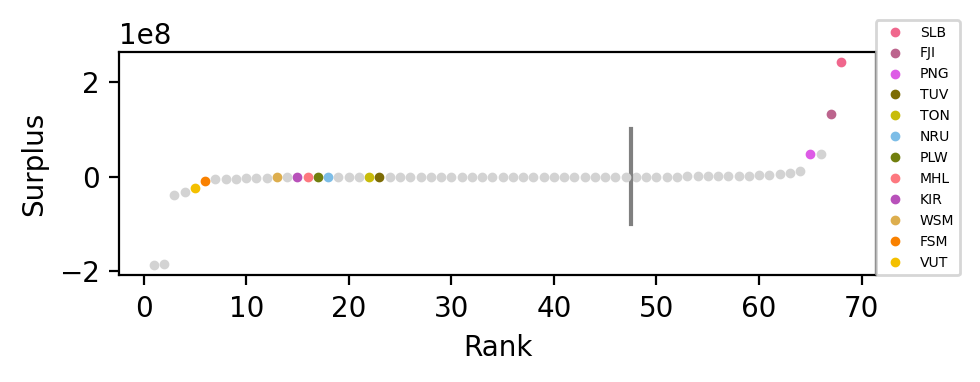

In [5]:
# visualize surplusses (in time-aggregated network) -- non-log y-scale

fi,ax = plt.subplots(1,figsize=(5,2),dpi=200)

sign = 1

for j,(v,sur) in enumerate(sorted(surplus.items(),key = lambda z:z[1],reverse=True)):
    
    # mark where it goes from positive to negative
    if sign!=np.sign(sur):
        plt.plot([len(nodes)-j+0.5,len(nodes)-j+0.5],[-int(10**8),int(10**8)],color='grey')
    sign = np.sign(sur)

    # label PICs with color 
    la = v if v in PICs else None
    plt.plot( [len(nodes)-j], [sur], '.', ms=5, color=co[v], label=la )

plt.legend( loc=(1,0), fontsize=5 )

plt.ylabel('Surplus')
plt.xlabel('Rank')

plt.tight_layout()

plt.savefig('figs/surplus_lin.pdf')

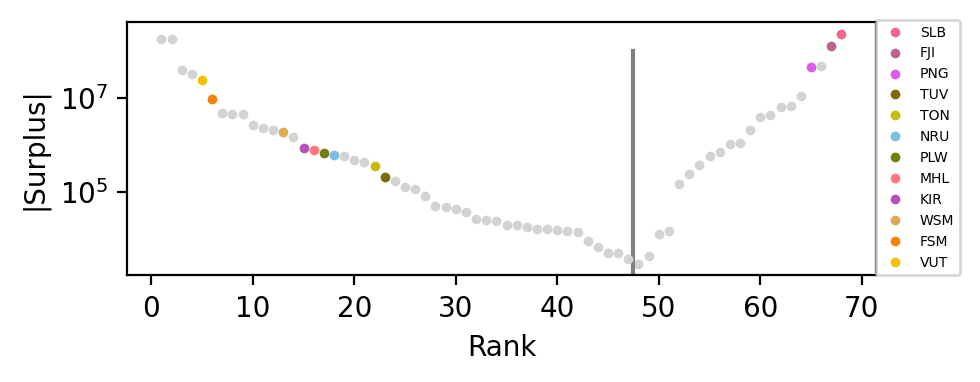

In [6]:
# visualize surplusses (in time-aggregated network) -- log scale (all values made positive)

fi,ax = plt.subplots(1,figsize=(5,2),dpi=200)

sign = 1

for j,(v,sur) in enumerate(sorted(surplus.items(),key = lambda z:z[1],reverse=True)):
    
    # mark where it goes from positive to negative
    if sign!=np.sign(sur):
        plt.plot([len(nodes)-j+0.5,len(nodes)-j+0.5],[-int(10**8),int(10**8)],color='grey')
    sign = np.sign(sur)

    # label PICs with color 
    la = v if v in PICs else None
    plt.semilogy( [len(nodes)-j], [np.abs(sur)], '.', ms=5, color=co[v], label=la )

plt.legend( loc=(1,0), fontsize=5 )

plt.ylabel('|Surplus|')
plt.xlabel('Rank')

plt.tight_layout()

plt.savefig('figs/abs_surplus_logscale.pdf')